# Machine Learning Signal Predicting Return

In [1]:
%pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [42]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning libraries
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, learning_curve, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_theme(style='whitegrid')

## Load Dataset

In [43]:
# Load the new training dataset
df_train = pd.read_csv('../regression_training.csv')

# Load the new testing dataset
df_test = pd.read_csv('../data/regression_testing.csv')

# Display the first few rows of training data
print("Training Data:")
display(df_train.head())

# Display the first few rows of testing data
print("Testing Data:")
display(df_test.head())

# Check the shapes of the datasets
print(f"Training dataset contains {df_train.shape[0]} rows and {df_train.shape[1]} columns.")
print(f"Testing dataset contains {df_test.shape[0]} rows and {df_test.shape[1]} columns.")

Training Data:


,Date,Active,Target_10,Target_30,Target_60,Target_120,Target_300,Momentum_10,Momentum_30,Momentum_60,...,BB_10,BB_30,BB_60,BB_120,BB_300,MRC_10,MRC_30,MRC_60,MRC_120,MRC_300
0,2024-02-05 00:00:00+00:00,AAVEUSDT.csv,0.000361,0.001924,-0.005772,-0.006854,0.007456,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
1,2024-02-05 00:00:00+00:00,ADAUSDT.csv,0.001217,0.003043,-0.002637,-0.001826,0.007302,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
2,2024-02-05 00:00:00+00:00,ALGOUSDT.csv,-0.001260,-0.001890,-0.007561,-0.005671,0.001260,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
3,2024-02-05 00:00:00+00:00,ATOMUSDT.csv,0.000335,0.001115,-0.005798,-0.004683,0.003011,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
4,2024-02-05 00:00:00+00:00,AVAXUSDT.csv,0.000287,0.002872,-0.004308,0.002585,0.002585,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN


Testing Data:


,Date,Active,Target_10,Target_30,Target_60,Target_120,Target_300,Momentum_10,Momentum_30,Momentum_60,...,BB_10,BB_30,BB_60,BB_120,BB_300,MRC_10,MRC_30,MRC_60,MRC_120,MRC_300
0,2024-06-02 00:00:00+00:00,AAVEUSDT.csv,0.000481,0.002404,0.004904,0.004231,0.008269,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
1,2024-06-02 00:00:00+00:00,ADAUSDT.csv,0.001112,0.002891,0.005338,0.004671,0.008452,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
2,2024-06-02 00:00:00+00:00,ALGOUSDT.csv,0.001595,-0.000532,0.002658,0.002658,-0.002127,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
3,2024-06-02 00:00:00+00:00,ATOMUSDT.csv,-0.000240,-0.000240,0.002403,0.004326,0.006969,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN
4,2024-06-02 00:00:00+00:00,AVAXUSDT.csv,-0.000559,0.000280,0.004755,0.006154,0.010350,NaN,NaN,NaN,...,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN


Training dataset contains 8496000 rows and 27 columns.
Testing dataset contains 91722 rows and 27 columns.


## Data Preparation and Feature Selection

In [44]:
import numpy as np

# Initial counts
print("Initial counts:")
print("df_train - NaNs:", df_train.isna().sum().sum(), ", Infinities:", np.isinf(df_train.select_dtypes(include=[np.number]).to_numpy()).sum())
print("df_test - NaNs:", df_test.isna().sum().sum(), ", Infinities:", np.isinf(df_test.select_dtypes(include=[np.number]).to_numpy()).sum())

# Replace infinities with NaNs
df_train.replace([np.inf, -np.inf], np.nan, inplace=True)
df_test.replace([np.inf, -np.inf], np.nan, inplace=True)

print("\nAfter replacing infinities with NaNs:")
print("df_train - NaNs:", df_train.isna().sum().sum(), ", Infinities:", np.isinf(df_train.select_dtypes(include=[np.number]).to_numpy()).sum())
print("df_test - NaNs:", df_test.isna().sum().sum(), ", Infinities:", np.isinf(df_test.select_dtypes(include=[np.number]).to_numpy()).sum())

# Remove rows where 'Momentum_300' or 'Target_300' is NaN
df_train = df_train.dropna(subset=['Momentum_300', 'Target_300'])
df_test = df_test.dropna(subset=['Momentum_300', 'Target_300'])

print("\nAfter dropping rows where 'Momentum_300' or 'Target_300' is NaN:")
print("df_train - NaNs:", df_train.isna().sum().sum(), ", Infinities:", np.isinf(df_train.select_dtypes(include=[np.number]).to_numpy()).sum())
print("df_test - NaNs:", df_test.isna().sum().sum(), ", Infinities:", np.isinf(df_test.select_dtypes(include=[np.number]).to_numpy()).sum())

# Fill remaining NaNs with zero
df_train.fillna(0, inplace=True)
df_test.fillna(0, inplace=True)

print("\nAfter filling remaining NaNs with zero:")
print("df_train - NaNs:", df_train.isna().sum().sum(), ", Infinities:", np.isinf(df_train.select_dtypes(include=[np.number]).to_numpy()).sum())
print("df_test - NaNs:", df_test.isna().sum().sum(), ", Infinities:", np.isinf(df_test.select_dtypes(include=[np.number]).to_numpy()).sum())


Initial counts:
df_train - NaNs: 116888 , Infinities: 44172
df_test - NaNs: 54318 , Infinities: 25154

After replacing infinities with NaNs:
df_train - NaNs: 161060 , Infinities: 0
df_test - NaNs: 79472 , Infinities: 0

After dropping rows where 'Momentum_300' or 'Target_300' is NaN:
df_train - NaNs: 0 , Infinities: 0
df_test - NaNs: 846 , Infinities: 0

After filling remaining NaNs with zero:
df_train - NaNs: 0 , Infinities: 0
df_test - NaNs: 0 , Infinities: 0


In [45]:
# --------------------------------------------------
# Identify Columns
# --------------------------------------------------

# Get all column names
all_columns = df_train.columns.tolist()

# Identify the 'Date' and 'Active' columns
date_column = 'Date'
active_column = 'Active'

# Identify target columns (those starting with 'Target_')
target_columns = [col for col in all_columns if col.startswith('Target_')]

# Choose one target column to analyze (e.g., 'Target_300')
target_column = 'Target_10'  # You can change this to any target you want

# Identify signal columns (those starting with known signal prefixes)
signal_prefixes = ['Momentum_', 'RSI_', 'BB_', 'MRC_']
signal_columns = [col for col in all_columns if any(col.startswith(prefix) for prefix in signal_prefixes)]

# Combine signal columns and 'Active' column
feature_columns = signal_columns + [active_column]

# Display the identified columns
print("\nIdentified Columns:")
print(f"Date Column: {date_column}")
print(f"Active Column: {active_column}")
print(f"Target Columns: {target_columns}")
print(f"Selected Target Column for Analysis: {target_column}")
print(f"Signal Columns ({len(signal_columns)} features): {signal_columns}")


Identified Columns:
Date Column: Date
Active Column: Active
Target Columns: ['Target_10', 'Target_30', 'Target_60', 'Target_120', 'Target_300']
Selected Target Column for Analysis: Target_10
Signal Columns (20 features): ['Momentum_10', 'Momentum_30', 'Momentum_60', 'Momentum_120', 'Momentum_300', 'RSI_10', 'RSI_30', 'RSI_60', 'RSI_120', 'RSI_300', 'BB_10', 'BB_30', 'BB_60', 'BB_120', 'BB_300', 'MRC_10', 'MRC_30', 'MRC_60', 'MRC_120', 'MRC_300']


## Exploratory Data Analysis (EDA)

In [46]:
# --------------------------------------------------
# Data Overview
# --------------------------------------------------

# Check data types
print("\nData Types:")
print(df_train.dtypes)

# Summary statistics of numerical columns
print("\nSummary Statistics of Numerical Columns:")
display(df_train.describe())

# Summary statistics of categorical columns
print("\nSummary Statistics of Categorical Columns:")
display(df_train.describe(include=['object', 'category']))

# Check for missing values (should be zero after filling)
print("\nMissing Values in the Dataset:")
missing_values = df_train.isnull().sum()
print(missing_values[missing_values > 0])


Data Types:
Date             object
Active           object
Target_10       float64
Target_30       float64
Target_60       float64
Target_120      float64
Target_300      float64
Momentum_10     float64
Momentum_30     float64
Momentum_60     float64
Momentum_120    float64
Momentum_300    float64
RSI_10          float64
RSI_30          float64
RSI_60          float64
RSI_120         float64
RSI_300         float64
BB_10           float64
BB_30           float64
BB_60           float64
BB_120          float64
BB_300          float64
MRC_10          float64
MRC_30          float64
MRC_60          float64
MRC_120         float64
MRC_300         float64
dtype: object

Summary Statistics of Numerical Columns:


,Target_10,Target_30,Target_60,Target_120,Target_300,Momentum_10,Momentum_30,Momentum_60,Momentum_120,Momentum_300,...,BB_10,BB_30,BB_60,BB_120,BB_300,MRC_10,MRC_30,MRC_60,MRC_120,MRC_300
count,8.451050e+06,8.451050e+06,8.451050e+06,8.451050e+06,8.451050e+06,8.451050e+06,8.451050e+06,8.451050e+06,8.451050e+06,8.451050e+06,...,8.451050e+06,8.451050e+06,8.451050e+06,8.451050e+06,8.451050e+06,8.451050e+06,8.451050e+06,8.451050e+06,8.451050e+06,8.451050e+06
mean,2.484974e-05,7.390069e-05,1.479356e-04,2.933185e-04,7.166008e-04,2.973650e-02,4.354418e-02,3.916012e-02,4.335258e-02,4.369787e-02,...,5.050373e-01,5.063015e-01,5.071691e-01,5.071094e-01,5.070404e-01,7.014143e-03,8.361026e-03,9.101281e-03,8.917982e-03,9.067075e-03
std,4.610085e-03,7.942945e-03,1.126641e-02,1.577287e-02,2.430324e-02,1.854586e+00,1.835031e+00,1.822439e+00,1.815831e+00,1.804801e+00,...,3.117115e-01,3.114274e-01,3.113171e-01,3.116019e-01,3.114756e-01,3.016737e-01,2.905367e-01,2.844418e-01,2.811702e-01,2.788338e-01
min,-2.177814e-01,-2.215909e-01,-2.354517e-01,-2.753315e-01,-3.578947e-01,-1.456360e+01,-1.227313e+01,-1.240684e+01,-1.895810e+01,-1.360757e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-9.299123e-01,-9.060930e-01,-1.000000e+00,-9.394456e-01
25%,-1.868618e-03,-3.163647e-03,-4.416961e-03,-6.016218e-03,-9.492880e-03,-1.219329e+00,-1.196450e+00,-1.190110e+00,-1.185265e+00,-1.181185e+00,...,2.400049e-01,2.436412e-01,2.462863e-01,2.462170e-01,2.466970e-01,-2.248940e-01,-2.104903e-01,-2.028921e-01,-1.986978e-01,-1.956044e-01
50%,0.000000e+00,0.000000e+00,0.000000e+00,1.391788e-04,3.445910e-04,0.000000e+00,3.048961e-02,3.959800e-02,4.095690e-02,5.151870e-02,...,5.106233e-01,5.126750e-01,5.129274e-01,5.136029e-01,5.140260e-01,1.027721e-02,1.150088e-02,1.193325e-02,1.237507e-02,1.272624e-02
75%,1.918465e-03,3.273322e-03,4.612546e-03,6.379310e-03,1.028278e-02,1.277591e+00,1.279532e+00,1.264810e+00,1.272726e+00,1.267761e+00,...,7.713155e-01,7.699502e-01,7.701094e-01,7.696018e-01,7.687068e-01,2.411616e-01,2.285336e-01,2.229138e-01,2.183051e-01,2.154857e-01
max,2.795747e-01,6.645635e-01,6.797870e-01,7.479050e-01,7.545212e-01,1.682936e+01,1.355275e+01,1.277135e+01,1.426594e+01,1.607466e+01,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,9.454423e-01,1.000000e+00,1.000000e+00,9.467926e-01



Summary Statistics of Categorical Columns:


,Date,Active
count,8451050,8451050
unique,169021,50
top,2024-06-01 18:59:00+00:00,AAVEUSDT.csv
freq,50,169021



Missing Values in the Dataset:
Series([], dtype: int64)


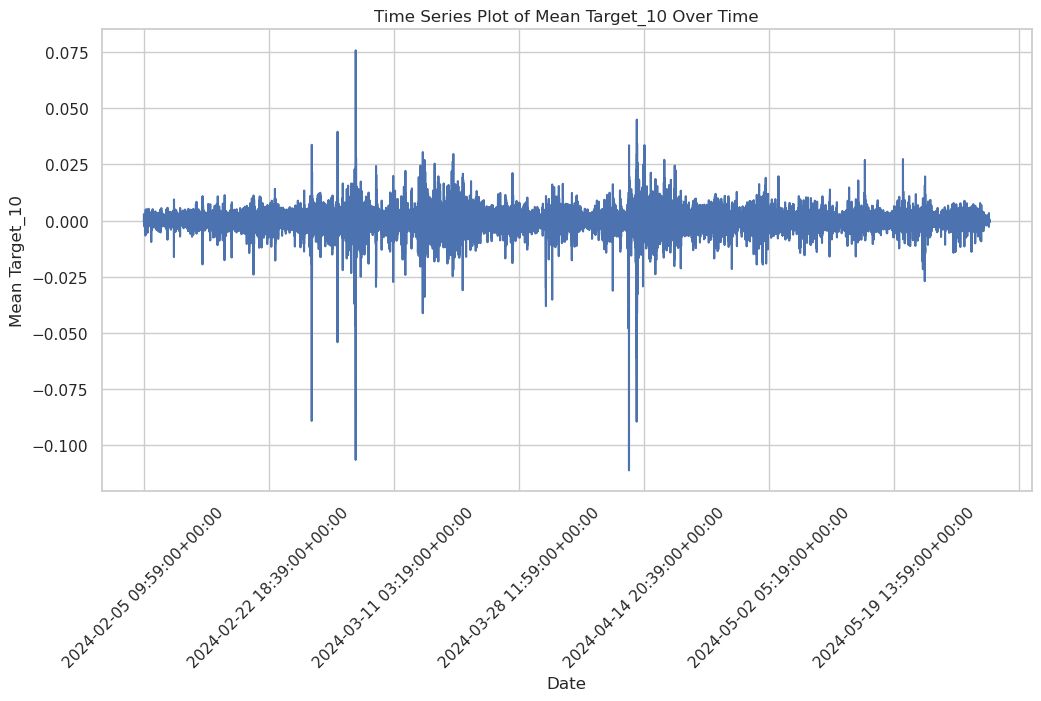

In [47]:
# --------------------------------------------------
# Target Variable Analysis
# --------------------------------------------------

# Time series plot of the target variable (aggregate over time)
plt.figure(figsize=(12, 6))
df_train.groupby(date_column)[target_column].mean().plot()
plt.title(f'Time Series Plot of Mean {target_column} Over Time')
plt.xlabel('Date')
plt.ylabel(f'Mean {target_column}')
plt.xticks(rotation=45)
plt.show()


Numerical Signal Columns:
['Momentum_10', 'Momentum_30', 'Momentum_60', 'Momentum_120', 'Momentum_300', 'RSI_10', 'RSI_30', 'RSI_60', 'RSI_120', 'RSI_300', 'BB_10', 'BB_30', 'BB_60', 'BB_120', 'BB_300', 'MRC_10', 'MRC_30', 'MRC_60', 'MRC_120', 'MRC_300']

Categorical Columns:
['Active']

Top 10 features most correlated with the target variable:
Momentum_30     0.011726
Momentum_300    0.008766
RSI_30          0.008239
Momentum_120    0.008092
MRC_300         0.008066
MRC_120         0.007782
BB_300          0.007766
MRC_60          0.007560
BB_60           0.007084
BB_120          0.007048
Name: Target_10, dtype: float64


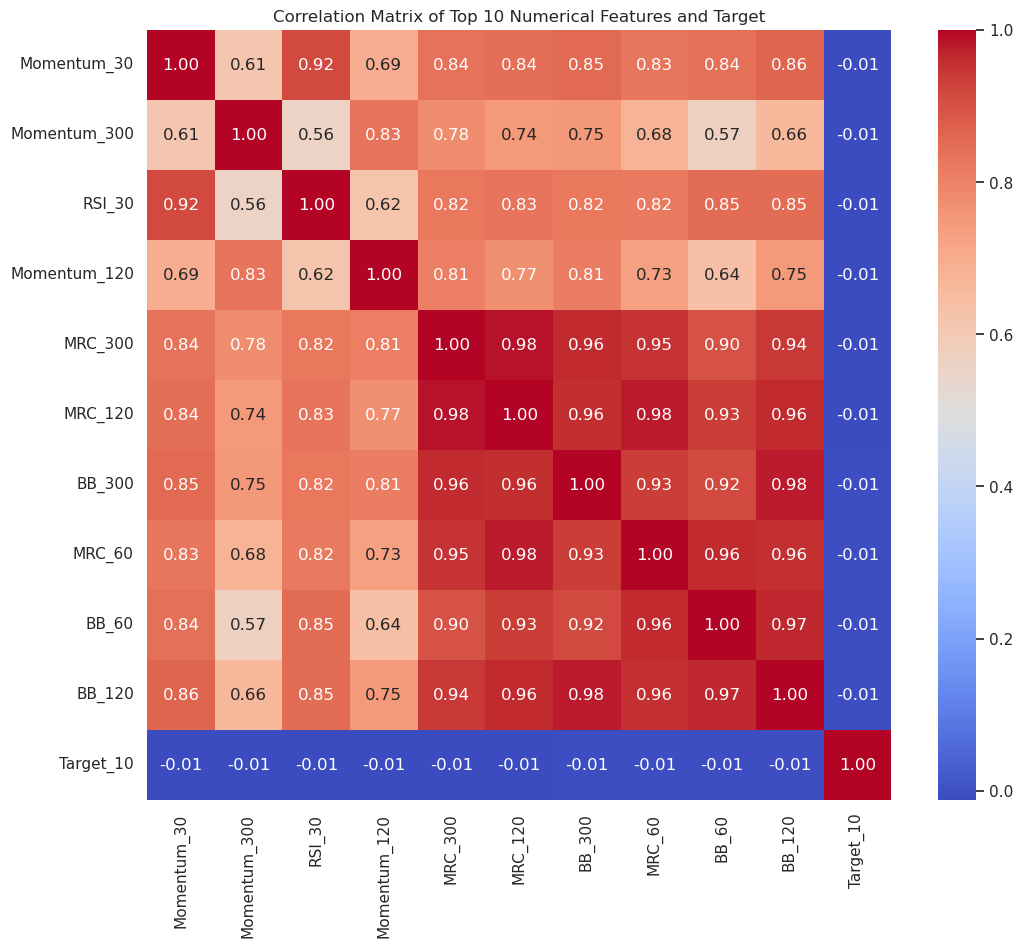

In [48]:
# --------------------------------------------------
# Feature Analysis
# --------------------------------------------------

# Identify numerical and categorical features
numerical_cols = df_train[signal_columns].select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [active_column]

print("\nNumerical Signal Columns:")
print(numerical_cols)

print("\nCategorical Columns:")
print(categorical_cols)

# Correlation matrix
corr_matrix = df_train[numerical_cols + [target_column]].corr()
# Calculate correlations with the target variable
corr_with_target = corr_matrix[target_column].drop(target_column).abs().sort_values(ascending=False)

# Set a threshold or select top N features
top_n = 10  # You can adjust this number
top_features = corr_with_target.head(top_n).index.tolist()

print(f"\nTop {top_n} features most correlated with the target variable:")
print(corr_with_target.head(top_n))

# Update numerical_cols to include only top features
numerical_cols_top = top_features

# Update the correlation matrix to include only top features
corr_matrix_top = df_train[numerical_cols_top + [target_column]].corr()

# Plot the correlation matrix for top features
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix_top, annot=True, fmt='.2f', cmap='coolwarm')
plt.title(f'Correlation Matrix of Top {top_n} Numerical Features and Target')
plt.show()

# ------ UNCOMMENT BELOW IF YOU WANT TO SEE THE DISTRIBUTION OF THE TOP 10 FEATURES ------
# top_n = 10
# fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 rows, 5 columns

# for i, col in enumerate(numerical_cols_top[:top_n]):
#     row = i // 5  # Determine the row index
#     col_idx = i % 5  # Determine the column index within the row
#     sns.histplot(df_train[col], bins=50, kde=True, ax=axes[row, col_idx])
#     axes[row, col_idx].set_title(f'Distribution of {col}')
#     axes[row, col_idx].set_xlabel(col)
#     axes[row, col_idx].set_ylabel('Frequency')

# plt.tight_layout()  # Adjust layout to prevent overlap
# plt.show()

In [49]:
# --------------------------------------------------
# Outlier Detection
# --------------------------------------------------

# Using z-score to identify outliers and remove them
from scipy import stats

outlier_indices = {}
threshold = 3
for col in numerical_cols:
    z_scores = np.abs(stats.zscore(df_train[col].dropna()))
    outlier_idx = np.where(z_scores > threshold)[0]
    outlier_indices[col] = outlier_idx
    print(f"\nNumber of outliers detected in {col} with Z > {threshold}: {len(outlier_idx)}")

# outlier_rows = set()
# for indices in outlier_indices.values():
#     outlier_rows.update(indices)

# # Filter out the rows with outliers
# df_train_filtered = df_train.drop(df_train.index[list(outlier_rows)])
# print(f"\nDataframe shape after outlier removal: {df_train_filtered.shape}")


Number of outliers detected in Momentum_10 with Z > 3: 48931

Number of outliers detected in Momentum_30 with Z > 3: 44859

Number of outliers detected in Momentum_60 with Z > 3: 46437

Number of outliers detected in Momentum_120 with Z > 3: 44125

Number of outliers detected in Momentum_300 with Z > 3: 42945

Number of outliers detected in RSI_10 with Z > 3: 30522

Number of outliers detected in RSI_30 with Z > 3: 38882

Number of outliers detected in RSI_60 with Z > 3: 41367

Number of outliers detected in RSI_120 with Z > 3: 45110

Number of outliers detected in RSI_300 with Z > 3: 47077

Number of outliers detected in BB_10 with Z > 3: 0

Number of outliers detected in BB_30 with Z > 3: 0

Number of outliers detected in BB_60 with Z > 3: 0

Number of outliers detected in BB_120 with Z > 3: 0

Number of outliers detected in BB_300 with Z > 3: 0

Number of outliers detected in MRC_10 with Z > 3: 64

Number of outliers detected in MRC_30 with Z > 3: 160

Number of outliers detected i

In [50]:
# --------------------------------------------------
# Conclusion of EDA
# --------------------------------------------------

print("\nConclusion of EDA:")
print(f"- The dataset contains {df_train.shape[0]} rows and {df_train.shape[1]} columns.")
print(f"- The target variable '{target_column}' has a mean of {df_train[target_column].mean():.4f} and a standard deviation of {df_train[target_column].std():.4f}.")
# print(f"- Missing values are present in the following columns:")
print(missing_values[missing_values > 0])
# print(f"- The features '{moderately_corr_features}' show higher correlation with the target variable.")



Conclusion of EDA:
- The dataset contains 8451050 rows and 27 columns.
- The target variable 'Target_10' has a mean of 0.0000 and a standard deviation of 0.0046.
Series([], dtype: int64)


## Data Splitting and Model Building

In [51]:
# --------------------------------------------------
# Prepare Features and Target
# --------------------------------------------------
# Reduce DataFrame size by selecting every third line
df_train = df_train.iloc[::5]  # Select every third row

# # Prepare the features and target for training
X_train = df_train[feature_columns]
y_train = df_train[target_column]

# # Prepare the features and target for testing
X_test = df_test[feature_columns]
y_test = df_test[target_column]

In [52]:
# At this point, missing values and infinities have been handled already.

# Verify that there are no missing or infinite values
print("\nMissing values in training features after preprocessing:")
print(X_train.isnull().sum().sum())

print("\nMissing values in testing features after preprocessing:")
print(X_test.isnull().sum().sum())


Missing values in training features after preprocessing:
0

Missing values in testing features after preprocessing:
0


In [53]:
# --------------------------------------------------
# Identify Numerical and Categorical Columns
# --------------------------------------------------

# Identify numerical columns
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Update the feature columns to include only numerical columns
feature_columns = numerical_cols

# Update X_train and X_test
X_train = df_train[feature_columns]
X_test = df_test[feature_columns]

In [54]:
# --------------------------------------------------
# Identify Numerical and Categorical Columns
# --------------------------------------------------

# Identify numerical columns
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Identify categorical columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Ensure 'Active' is treated as categorical
if active_column not in categorical_cols:
    categorical_cols.append(active_column)
    if active_column in numerical_cols:
        numerical_cols.remove(active_column)

print("\nNumerical columns:", numerical_cols)
print("Categorical columns:", categorical_cols)


Numerical columns: ['Momentum_10', 'Momentum_30', 'Momentum_60', 'Momentum_120', 'Momentum_300', 'RSI_10', 'RSI_30', 'RSI_60', 'RSI_120', 'RSI_300', 'BB_10', 'BB_30', 'BB_60', 'BB_120', 'BB_300', 'MRC_10', 'MRC_30', 'MRC_60', 'MRC_120', 'MRC_300']
Categorical columns: ['Active']


## Data Preprocessing

In [55]:
# --------------------------------------------------
# Preprocessing for XGBoost and RandomForest
# --------------------------------------------------

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Data Preprocessing Pipeline for numerical data only
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols)
    ]
)

# Preprocess the data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Convert the processed data back to DataFrame
X_train_processed = pd.DataFrame(X_train_processed, columns=numerical_cols, index=X_train.index)
X_test_processed = pd.DataFrame(X_test_processed, columns=numerical_cols, index=X_test.index)


## Model Training and Evaluation

In [56]:
# --------------------------------------------------
# Modeling with CatBoost
# --------------------------------------------------

# Define parameter distributions for RandomizedSearchCV
catboost_param_dist = {
    'iterations': [200, 300],
    'learning_rate': [0.05, 0.1],
    'depth': [4, 6],
    'random_seed': [42]
}

catboost_model = CatBoostRegressor(verbose=0)

# Use TimeSeriesSplit for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

catboost_random_search = RandomizedSearchCV(
    estimator=catboost_model,
    param_distributions=catboost_param_dist,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    n_iter=10,
    random_state=42
)

# Fit the CatBoost model without specifying cat_features
catboost_random_search.fit(X_train, y_train)

# Save the best CatBoost model after RandomizedSearchCV
target_window = target_column.split('_')[-1]
catboost_random_search.best_estimator_.save_model(f'catboost_model_{target_window}.cbm')

# Evaluate CatBoost on test data
y_pred_catboost = catboost_random_search.predict(X_test)
mse_catboost = mean_squared_error(y_test, y_pred_catboost)
r2_catboost = r2_score(y_test, y_pred_catboost)
mae_catboost = mean_absolute_error(y_test, y_pred_catboost)

print("\nCatBoost Performance:")
print(f"MSE: {mse_catboost:.4f}")
print(f"MAE: {mae_catboost:.4f}")
print(f"R^2 Score: {r2_catboost:.4f}")


CatBoost Performance:
MSE: 0.0000
MAE: 0.0020
R^2 Score: -0.0533


In [57]:

# --------------------------------------------------
# Modeling with XGBoost
# --------------------------------------------------

from xgboost import XGBRegressor

# Define parameter distributions for RandomizedSearchCV
xgb_param_dist = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 6, 9],
    'random_state': [42],
    'objective': ['reg:squarederror']
}

xgb_model = XGBRegressor()

# Use RandomizedSearchCV
xgb_random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=xgb_param_dist,
    cv=tscv,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    n_iter=10,
    random_state=42
)

# Fit the XGBoost model
xgb_random_search.fit(
    X_train_processed,
    y_train,
    eval_set=[(X_test_processed, y_test)],
    verbose=False
)

xgb_random_search.best_estimator_.save_model(f'xgboost_model_{target_window}.json')

# Evaluate XGBoost on test data
y_pred_xgb = xgb_random_search.predict(X_test_processed)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)

print("\nXGBoost Performance:")
print(f"MSE: {mse_xgb:.4f}")
print(f"MAE: {mae_xgb:.4f}")
print(f"R^2 Score: {r2_xgb:.4f}")


XGBoost Performance:
MSE: 0.0000
MAE: 0.0020
R^2 Score: -0.0055


In [58]:
# --------------------------------------------------
# Modeling with RandomForest
# --------------------------------------------------

# Simplified RandomForest model
rf_model = RandomForestRegressor(
    n_estimators=30,
    max_depth=5,
    random_state=42,
    n_jobs=-1,
    max_samples=0.2
)

# Fit the RandomForest model (without GridSearchCV)
rf_model.fit(
    X_train_processed,
    y_train
)

# Evaluate RandomForest on test data
y_pred_rf = rf_model.predict(X_test_processed)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print("\nRandom Forest Performance:")
print(f"MSE: {mse_rf:.4f}")
print(f"MAE: {mae_rf:.4f}")
print(f"R^2 Score: {r2_rf:.4f}")


Random Forest Performance:
MSE: 0.0000
MAE: 0.0020
R^2 Score: -0.1170


In [59]:
# --------------------------------------------------
# Comparison of Models
# --------------------------------------------------

performance_df = pd.DataFrame({
    'Model': ['CatBoost', 'XGBoost'],
    'MSE': [mse_catboost, mse_xgb],
    'MAE': [mae_catboost, mae_xgb],
    'R^2 Score': [r2_catboost, r2_xgb]
})
print("\nModel Performance Comparison:")
display(performance_df)


Model Performance Comparison:


,Model,MSE,MAE,R^2 Score
0,CatBoost,0.000017,0.002031,-0.053323
1,XGBoost,0.000016,0.001963,-0.005522


## Model Comparison

In [60]:
# --------------------------------------------------
# Comparison of Models
# --------------------------------------------------

performance_df = pd.DataFrame({
    'Model': ['CatBoost', 'XGBoost', 'RandomForest'],
    'MSE': [mse_catboost, mse_xgb, mse_rf],
    'MAE': [mae_catboost, mae_xgb, mae_rf],
    'R^2 Score': [r2_catboost, r2_xgb, r2_rf]
})
print("\nModel Performance Comparison:")
display(performance_df)


Model Performance Comparison:


,Model,MSE,MAE,R^2 Score
0,CatBoost,0.000017,0.002031,-0.053323
1,XGBoost,0.000016,0.001963,-0.005522
2,RandomForest,0.000018,0.002011,-0.117045


## Feature Importance

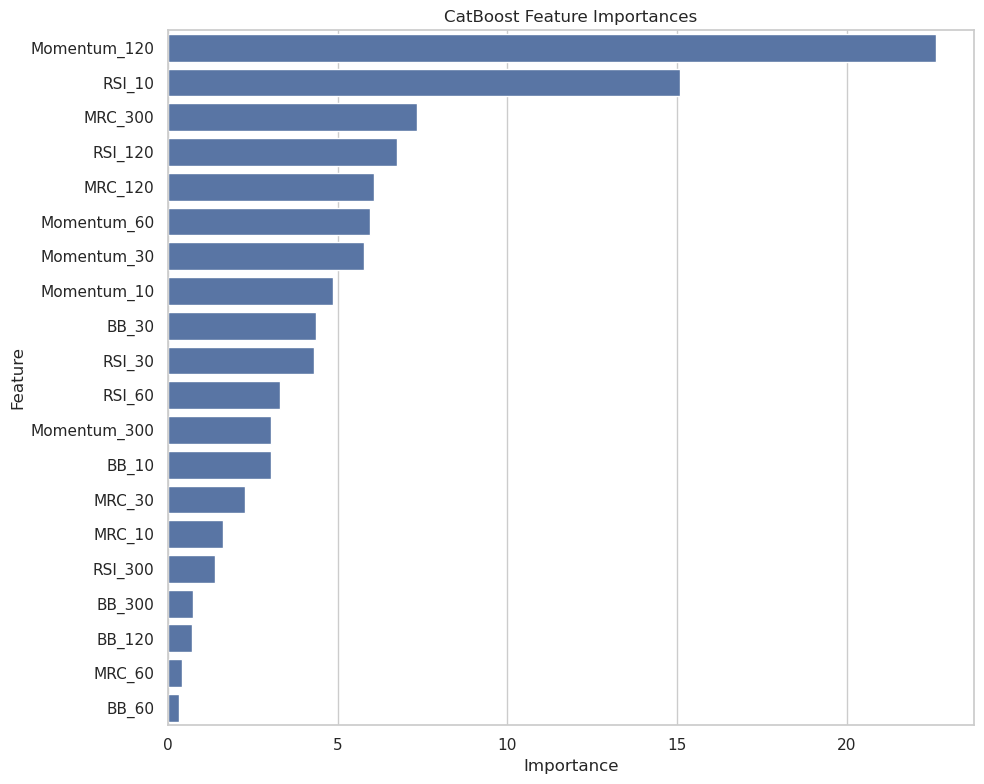

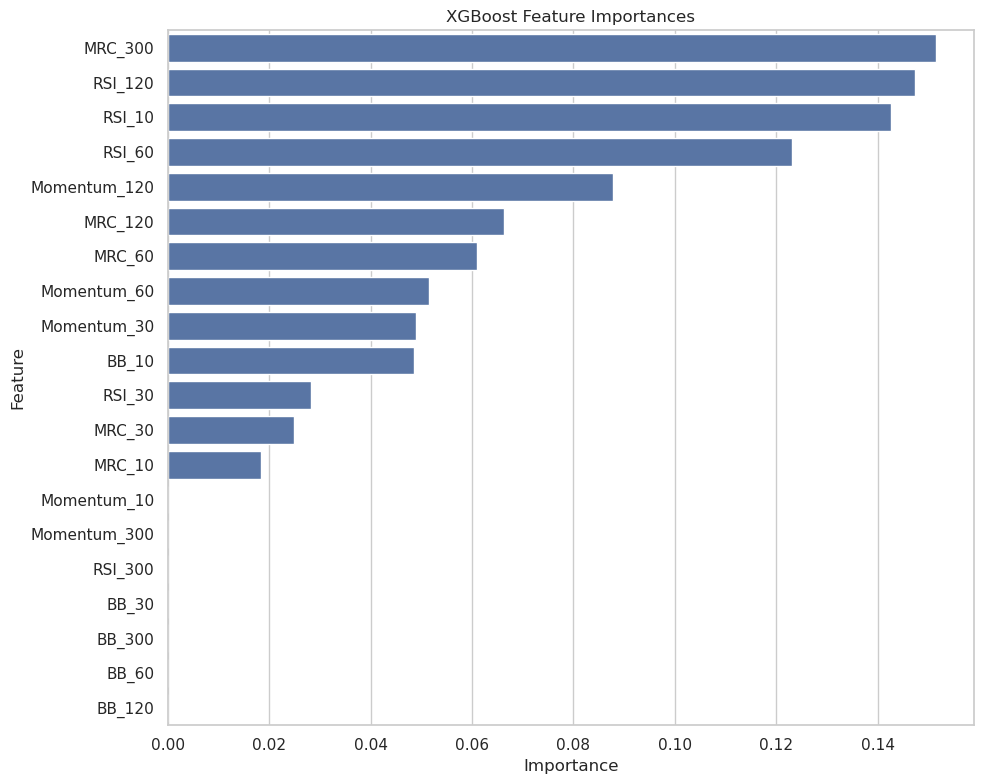

In [61]:
# --------------------------------------------------
# Feature Importance Analysis for CatBoost
# --------------------------------------------------

# Get the best model from RandomizedSearchCV
catboost_best_model = catboost_random_search.best_estimator_

# Ensure you have the list of feature names
catboost_feature_names = X_train.columns.tolist()

# Get feature importances
catboost_importance_values = catboost_best_model.get_feature_importance()
catboost_importance_df = pd.DataFrame({
    'Feature': catboost_feature_names,
    'Importance': catboost_importance_values
})

# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=catboost_importance_df.sort_values('Importance', ascending=False)
)
plt.title('CatBoost Feature Importances')
plt.tight_layout()
plt.show()

# --------------------------------------------------
# Feature Importance Analysis for XGBoost
# --------------------------------------------------

# Get the best model from RandomizedSearchCV
xgb_best_model = xgb_random_search.best_estimator_

# Ensure you have the list of feature names
xgb_feature_names = X_train_processed.columns.tolist()

# Get feature importances
xgb_importance = xgb_best_model.feature_importances_

# Create a DataFrame with feature importances
xgb_importance_df = pd.DataFrame({
    'Feature': xgb_feature_names,
    'Importance': xgb_importance
})

# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=xgb_importance_df.sort_values('Importance', ascending=False)
)
plt.title('XGBoost Feature Importances')
plt.tight_layout()
plt.show()